In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram

In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
X, y = make_classification(10000,
    n_features=10, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, class_sep=0.4
)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:,1]

In [5]:
xx, yy, scores = sklearn_curve_bootstrap(y_test, y_pred, metric='performance', 
                                         n_boot=30, groups=None, scorers=None, 
                            random_seed=42)

### Performance Diagram

To-Do: 

* Adding the table of scores 
* Labelling the dots 
* Mark highest CSI 
* Maybe add F1 score? 

<AxesSubplot:xlabel='Success Ratio (SR; 1-FAR)', ylabel='Probability of Detection (POD)'>

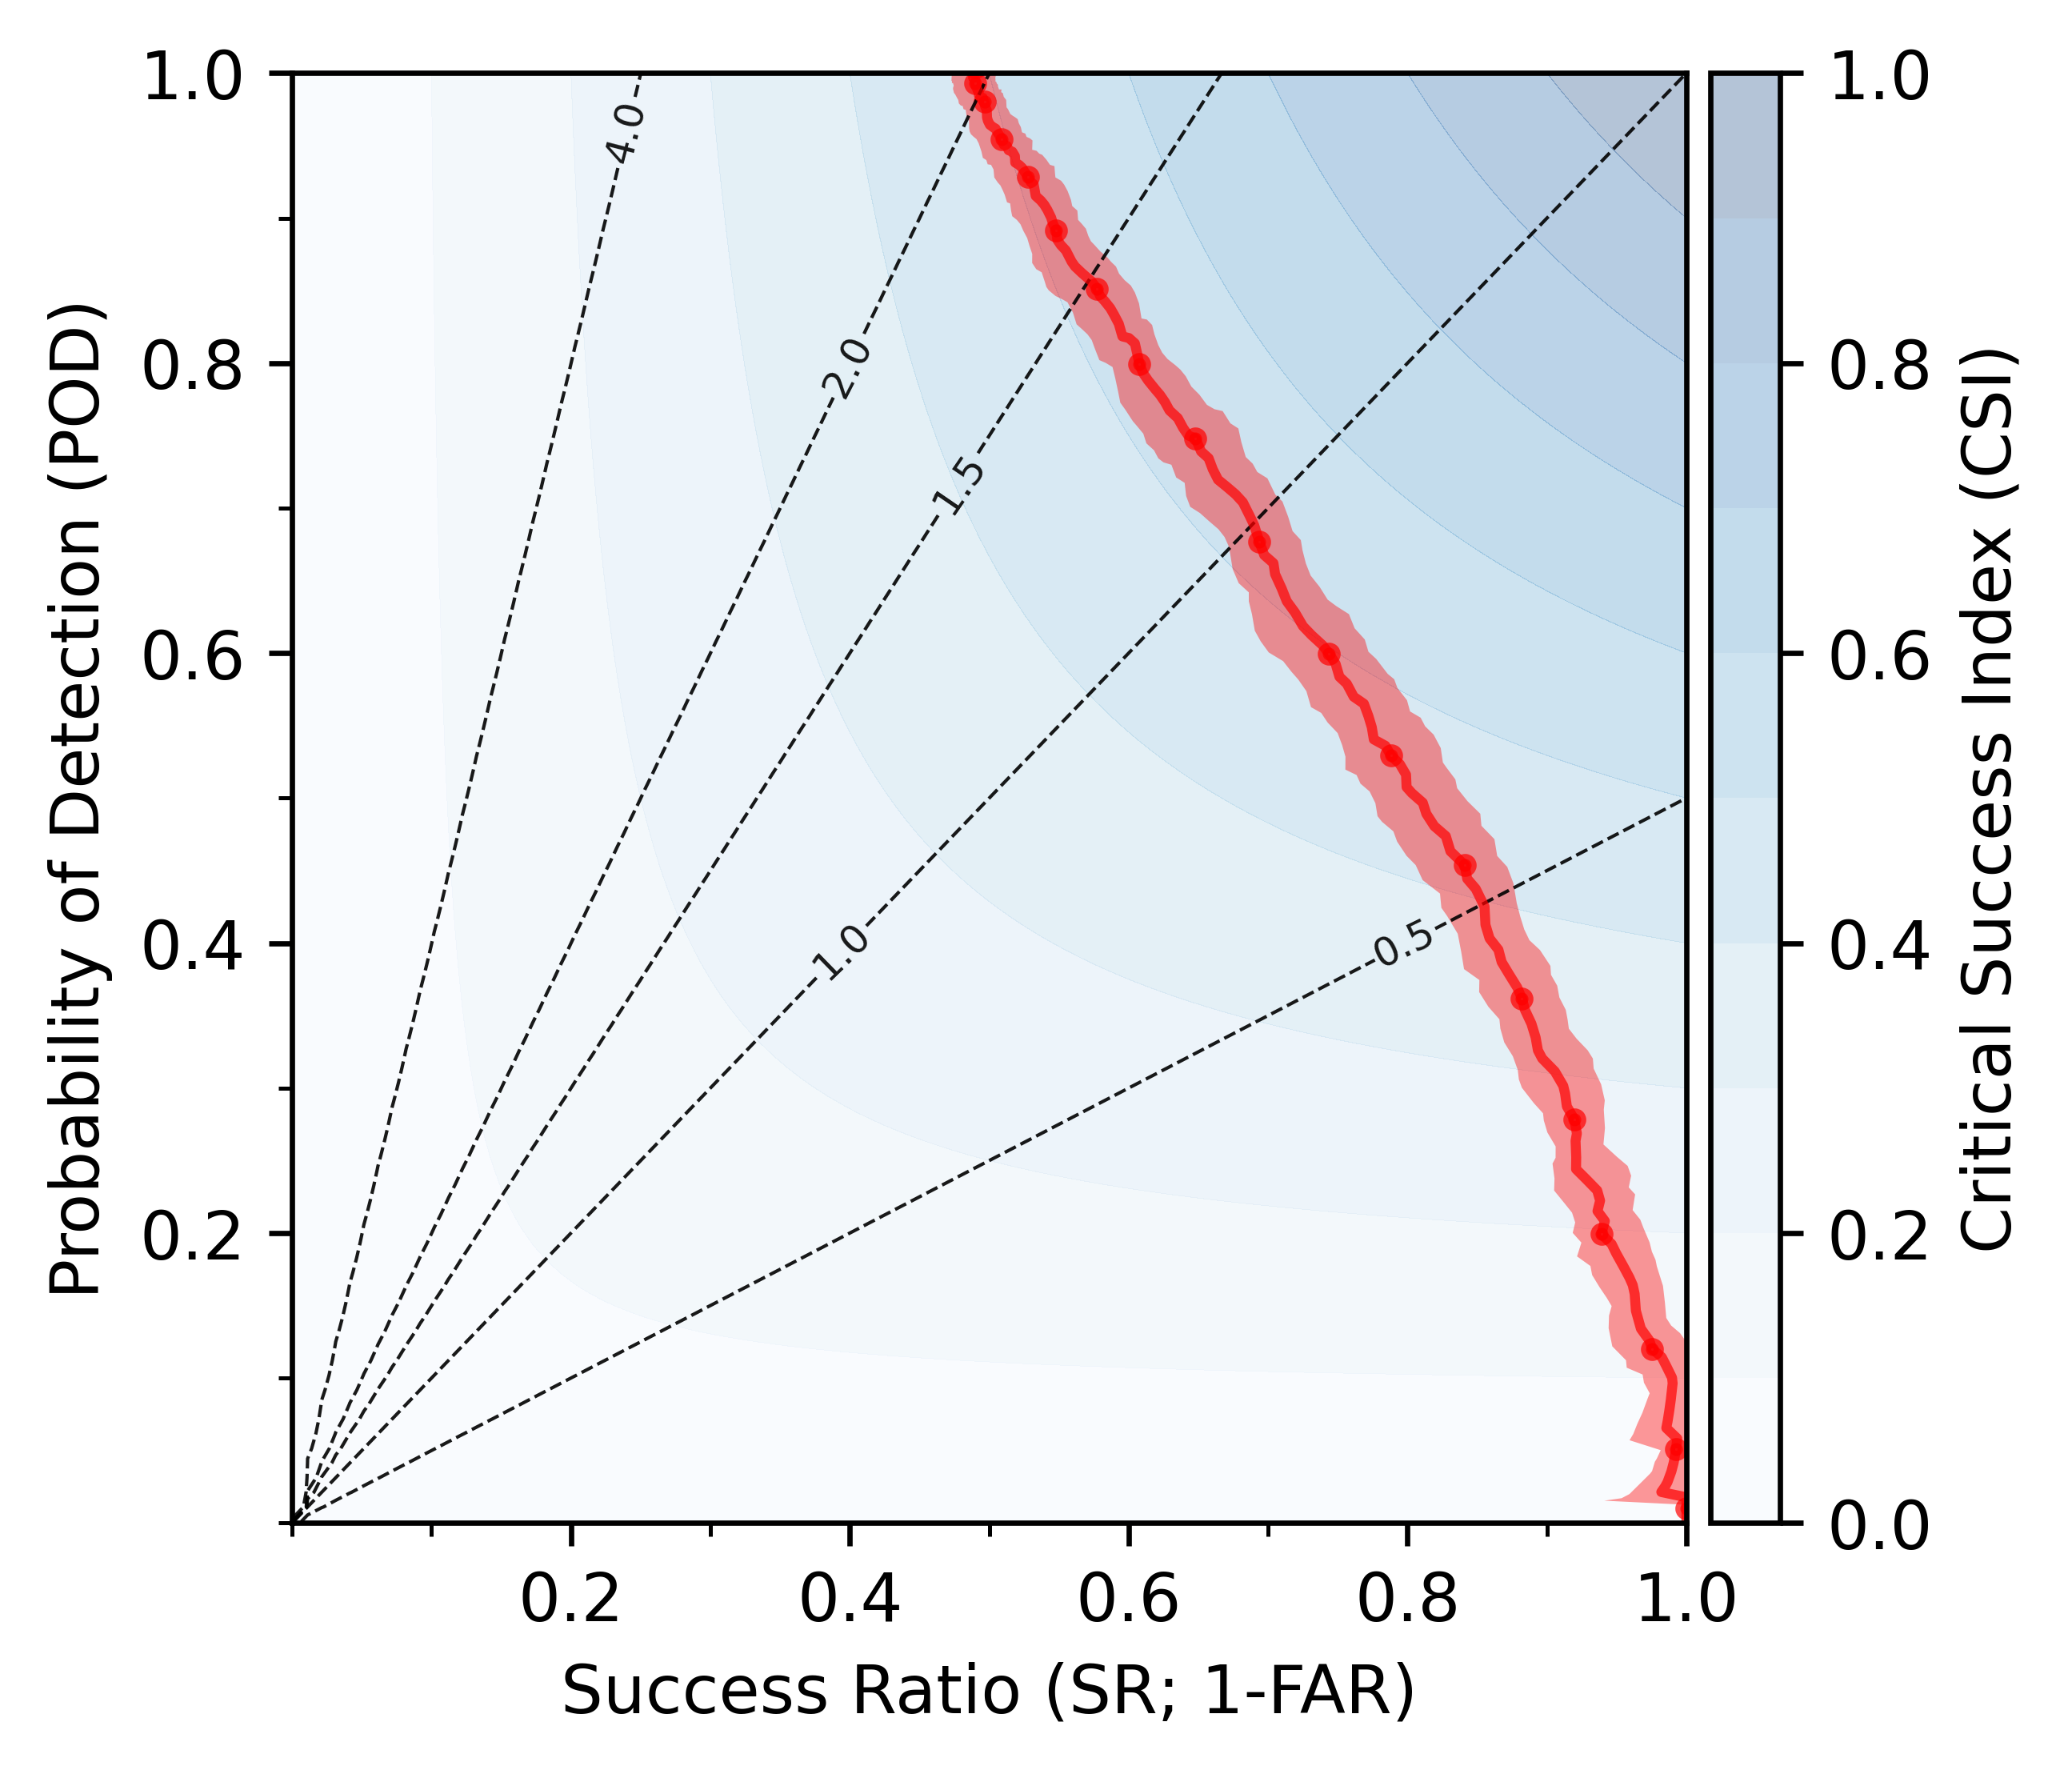

In [6]:
vd = VerificationDiagram()
vd.plot('performance', xx, yy)

### Multiple Performance Diagrams 

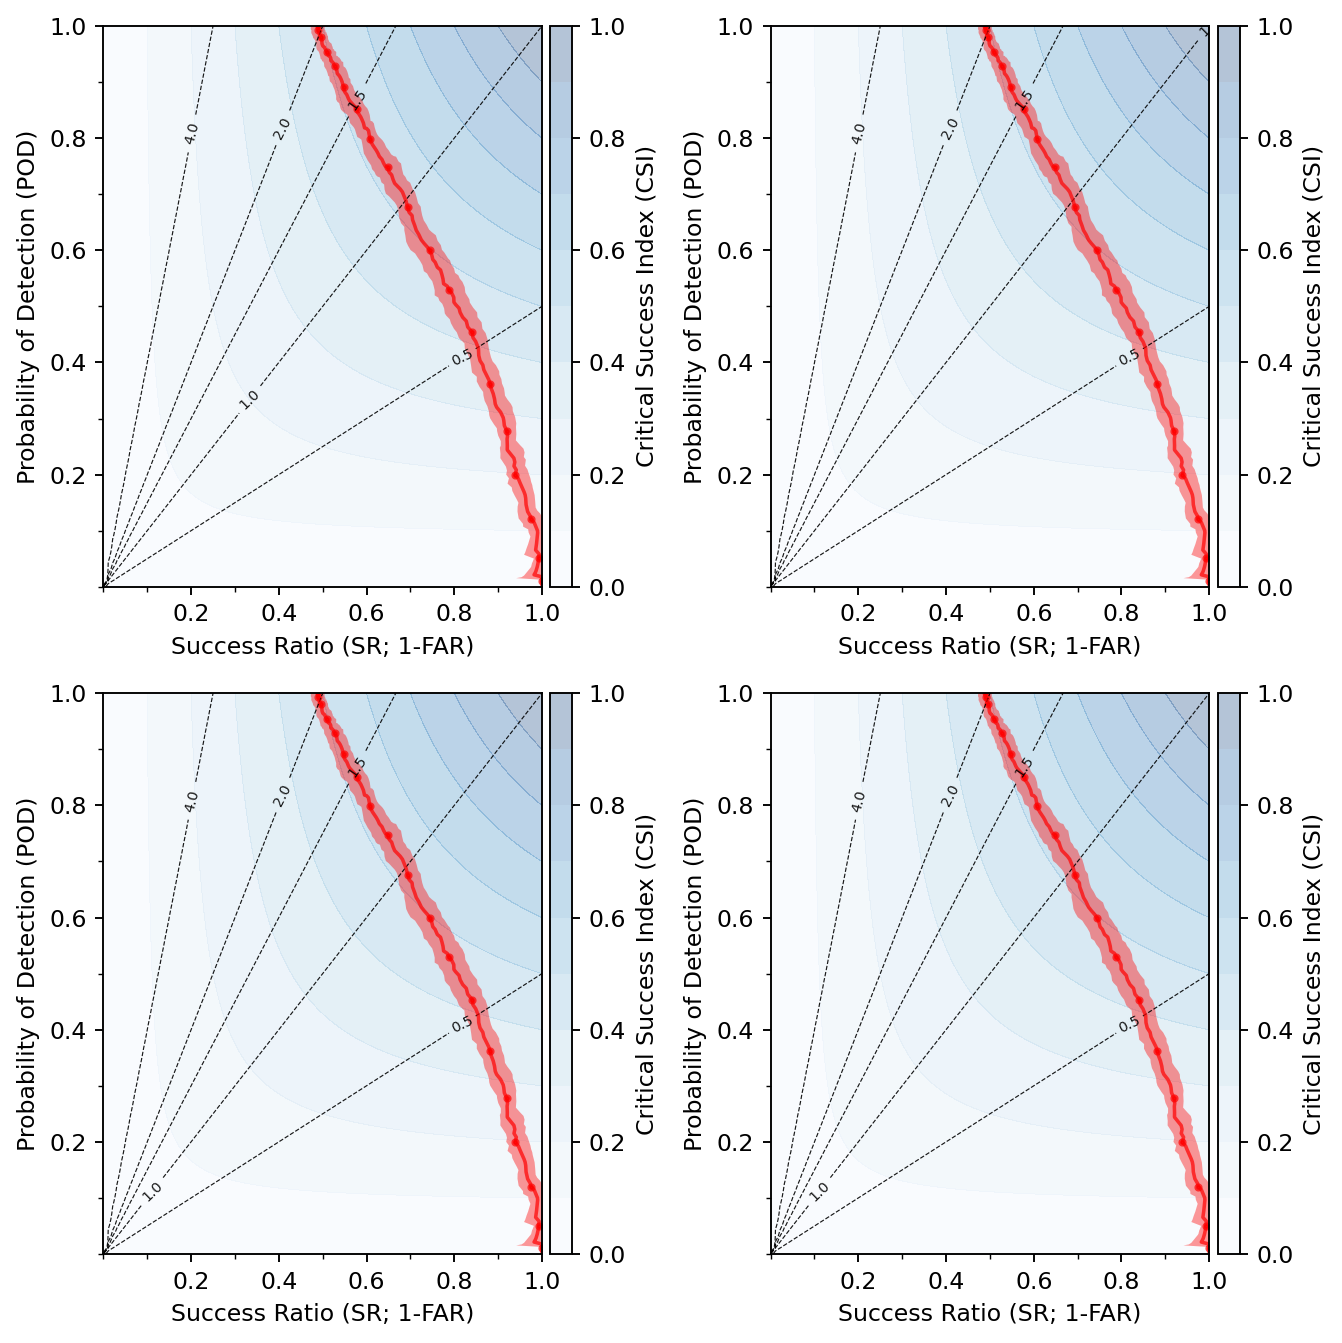

In [7]:
vd = VerificationDiagram()
fig, axes = plt.subplots(dpi=170, nrows=2, ncols=2, figsize=(8,8))
for ax in axes.flat:
    vd.plot('performance', xx, yy, ax=ax)
fig.tight_layout()

### ROC Diagram

In [10]:
vd = VerificationDiagram()
xx, yy, scores = sklearn_curve_bootstrap(y_test, y_pred, metric='roc', 
                                         n_boot=30, groups=None, scorers=None, 
                            random_seed=42)
vd.plot('roc', xx, yy)

TypeError: plot() got an unexpected keyword argument 'add_high_mark'

### Reliability Diagram 

To-Do list
* Re-think the inset figure. Often too small to be useful. Like the idea of having the graphic in the background
* Add the uncertainty bars 

Have the VerificationDiagram take y_true and y_pred as args. 

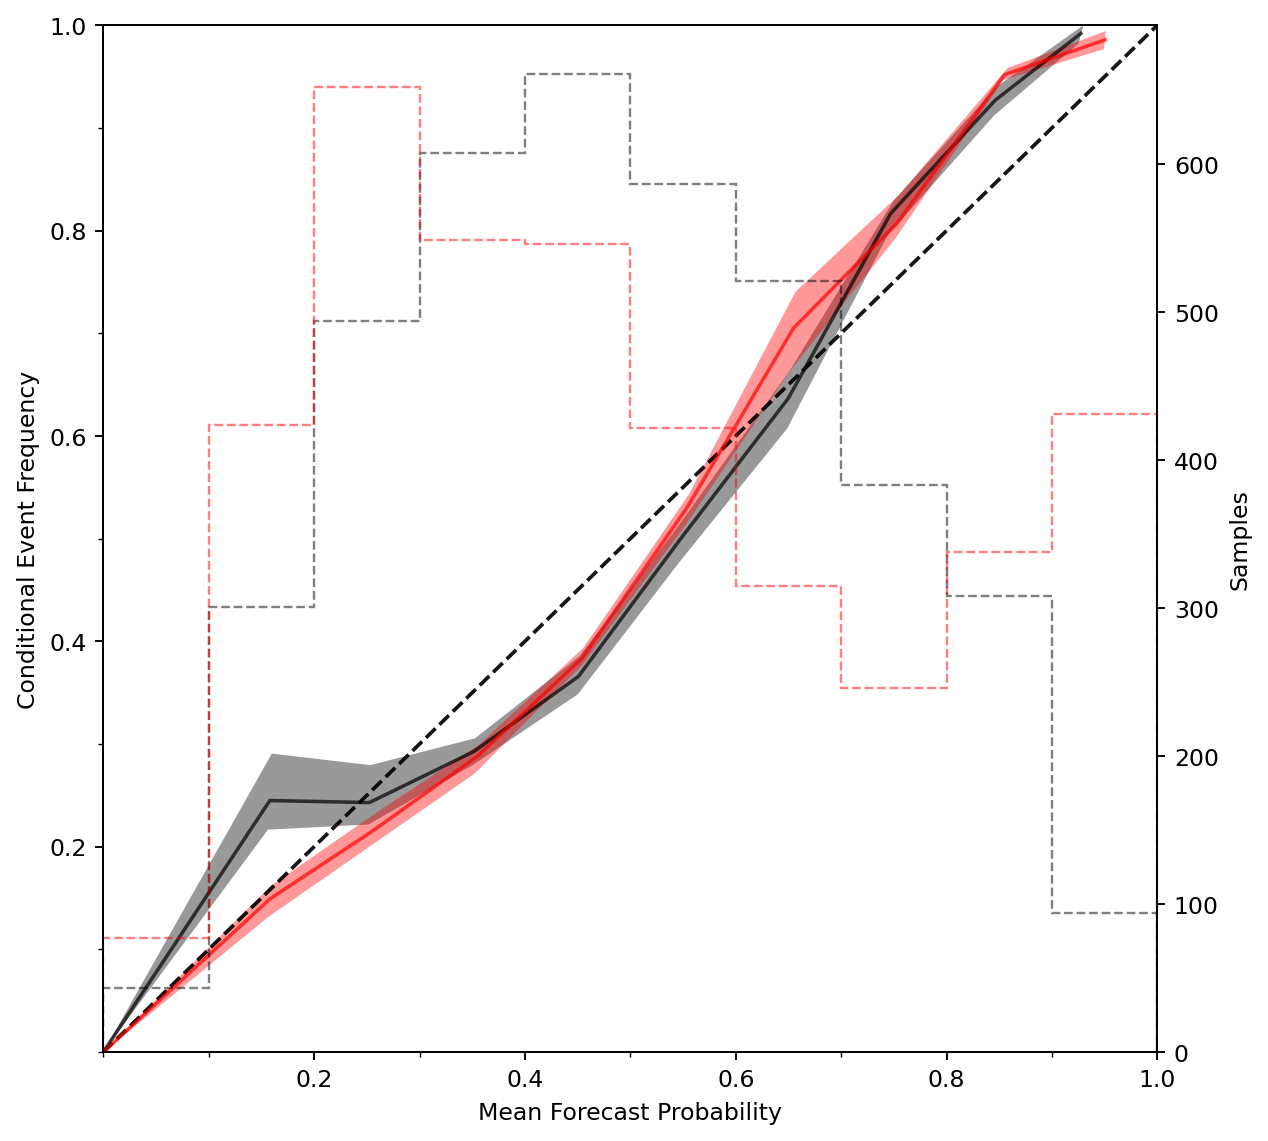

In [9]:
import numpy as np
vd = VerificationDiagram()
f, ax = plt.subplots(dpi=170, figsize=(8,8))
colors =['k', 'r', 'b']
# Add histogram
right_ax = ax.twinx()

models = [LogisticRegression(), RandomForestClassifier(), ]
for c, model in zip(colors, models):
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    xx, yy, scores = sklearn_curve_bootstrap(y_test, y_pred, metric='reliability', 
                                         n_boot=5, groups=None, scorers=None, 
                            random_seed=42)

    ax = vd.plot('reliability', xx, yy, line_colors=[c], ax=ax)

    right_ax.hist(y_pred, bins=np.arange(0,1.1,0.1),alpha=0.5, histtype='step', ls='dashed', color=c)
    right_ax.set_ylabel('Samples')